In [ ]:
df <- arrow::read_parquet(here("data", "featurefull.parquet") ) %>% relocate(starts_with("winner"), starts_with("looser"), starts_with("match"), starts_with("tournament"))
df %>% glimpse()

relocate: columns reordered (winner.name, winner.id, winner.rank, winner.bornAt, winner.height, …)



Rows: 17,926
Columns: 69
$ winner.name                     <chr> "Shuichi Sekiguchi", "Shuichi Sekiguch…
$ winner.id                       <chr> "sl92", "sl92", "sl92", "sl92", "tf58"…
$ winner.rank                     <int> 399, 399, 399, 399, 619, 619, 619, 619…
$ winner.bornAt                   <fct> USA, USA, USA, USA, Other, Other, Othe…
$ winner.height                   <dbl> 168, 168, 168, 168, 170, 170, 170, 170…
$ winner.Anwins                   <dbl> 5, 5, 5, 5, 6, 6, 6, 6, 18, 18, 11, 11…
$ winner.Anlosses                 <dbl> 10, 10, 10, 10, 4, 4, 4, 4, 15, 15, 5,…
$ winner.Anjogos                  <dbl> 15, 15, 15, 15, 10, 10, 10, 10, 33, 33…
$ winner.Awinrate                 <dbl> 33.33333, 33.33333, 33.33333, 33.33333…
$ winner.nwins                    <dbl> 353, 353, 353, 353, 166, 166, 166, 166…
$ winner.nlosses                  <dbl> 248, 248, 248, 248, 141, 141, 141, 141…
$ winner.njogos                   <dbl> 601, 601, 601, 601, 307, 307, 307, 307…
$ winner.winrat

In [ ]:
# vfold
set.seed(1)
df.folds <- vfold_cv(df, v = 5, repeats = 5) # no strata
df.folds %>% glimpse()

Rows: 25
Columns: 3
$ splits <list> [<vfold_split[14340 x 3586 x 17926 x 69]>], [<vfold_split[1434…
$ id     <chr> "Repeat1", "Repeat1", "Repeat1", "Repeat1", "Repeat1", "Repeat2…
$ id2    <chr> "Fold1", "Fold2", "Fold3", "Fold4", "Fold5", "Fold1", "Fold2", …


Algumas das nossas características são relações diretas de outras características, o que pode levar a problemas de multicolinariedade; portanto, vamos ter que escolher entre essas variáveis. Para isso, vamos ajustar vários modelos para cada conjunto de varíaveis de cada grupo, passo a passo, escolhendo o conjunto de cada grupo com melhor performance. Nesta secção vamos usar regressão logística, pela sua simplicidade.

Nota: aqui, players indica 2 colunas, uma de winner e outra de looser
* Rank:
    * players.rank
    * match.diffRank
    * match.avgRank
* Born:
    * players.bornAt
    * players.bornAt, players.bornAt.tournFreq
    * players.bornAt, players.bornAt.hasTourn
    * players.bornAt.tournFreq
    * players.bornAt.hasTourn
    * players.bornAt, match.playersBorn.hasTournXor
    * match.playersBorn.hasTournXor
    * players.bornAt, match.playersBorn.tournFreqDiff
    * match.playersBorn.tournFreqDiff
* Altura:
    * players.height
    * players.heightF
    * players.heightFC
    * match.diffHeights
    * match.avgHeights
    * match.heightFCvs
* Nº de jogos
    * players.nwins
    * players.nlosses
    * players.njogos
    * players.winrate, players.jogos
    * players.winrate
    * match.njogosDiff
* numero do torneio do jogador
    * player.nTournament
    * match.nTournamentDiff
* delay do torneio dos jogadores
    * player.lastTournamentDelay
* Mão dominante dos jogadores
    * match.domHands
* backhands dos jogadores
    * match.backhand
    * match.backHandsL1
    * match.backHandsL2
* ronda do tourneio
    * tournament.round
* se jogo teve tie breaker
    * match.hadTieBreaker
* terreno do torneio
    * tournament.ground
* duracao do torneio
    * tournament.duration
    * tournament.durationF
    * tournament.durationFL
* data do torneio num ano
    * tournament.quarter
    * tournament.quarterL1
    * tournament.quarterL2
    * tournament.month
* data do torneio
    * tournament.dateDistance
* recompensa do torneio
    * tournament.prize
    * tournament.smallPrize



In [ ]:
df.featureSelect.model <- workflow() %>%
    add_model(logistic_reg())
df.metrics <- metric_set(accuracy, f_meas, roc_auc, pr_auc)
df.featureSelect.model

══ Workflow ══════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: None
Model: logistic_reg()

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Logistic Regression Model Specification (classification)

Computational engine: glm 


In [ ]:
library(formulaic)
vars <- c(# variables with no direct correlation
    "winner.lastTournamentDelayW",
    "looser.lastTournamentDelayW",
    "match.domHands",
    "match.tournamentRound",
    "match.hadTieBreaker", 
    "tournament.dateDistance"
)
firstVars <- vars
form <- create.formula(input.names = vars, outcome.name = "match.setsCount", dat = df)
print(form$formula)
print(form$inclusion.table$include.variable)

match.setsCount ~ winner.lastTournamentDelayW + looser.lastTournamentDelayW + 
    match.domHands + match.tournamentRound + match.hadTieBreaker + 
    tournament.dateDistance
<environment: 0x00000174d2d8ce68>
[1] TRUE TRUE TRUE TRUE TRUE TRUE


In [ ]:
# primeiro modelo
library(tictoc)
tic()
df.featureSelect.model %>% add_formula(form$formula) %>% fit_resamples(df.folds, metrics = df.metrics, control = control_grid(save_pred = TRUE)) -> df.featureSelect.firstModel
toc(log=T)
collect_metrics(df.featureSelect.firstModel)

6.83 sec elapsed


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6765143,25,0.001659724,Preprocessor1_Model1
f_meas,binary,0.7796199,25,0.001374097,Preprocessor1_Model1
pr_auc,binary,0.7238419,25,0.002138314,Preprocessor1_Model1
roc_auc,binary,0.6125514,25,0.001584453,Preprocessor1_Model1


In [ ]:
# curva roc do primeiro
pred <- collect_predictions(df.featureSelect.firstModel)
pred %>% pROC::roc(match.setsCount, .pred_2) %>% ggroc()
ggsave(here("relatorio", "curva_roc.png"))

In [ ]:
featuresFit <- function(formula){
    tic()
    df.featureSelect.model %>% add_formula(formula$formula) %>% fit_resamples(df.folds, metrics = df.metrics) -> fitted
    toc(log=T)
    list(
        metrics = collect_metrics(fitted)                          %>% dplyr::select(metric = .metric, mean),
        preds   = collect_predictions(df.featureSelect.firstModel),
        roc     = collect_predictions(df.featureSelect.firstModel) %>% pROC::roc(match.setsCount, .pred_2)
    )
}
cformula <-  function(inputs) {
    create.formula(input.names = inputs, outcome.name = "match.setsCount", dat = df)
}
compare <- function(first, modelsToCompare) {
    final <- tibble(
        metric = first$metric,
        before = first$mean
    )
    # now add the other models as the difference to the first
    i = 0
    for (model in modelsToCompare) {
        i = i + 1
        final <- final %>% add_column(!!paste0("model", i) := model$mean - first$mean)
    }
    final
}

In [ ]:
# rank
firstModel  <- featuresFit(cformula(c(vars                              )))$metrics
directRanks <- featuresFit(cformula(c(vars, "winner.rank", "looser.rank")))$metrics
diffRanks   <- featuresFit(cformula(c(vars, "match.diffRank"            )))$metrics
avgRanks    <- featuresFit(cformula(c(vars, "match.avgRank"             )))$metrics
cbind(firstModel, directRanks, diffRanks, avgRanks)

6.85 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



6.69 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



5.86 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



6.18 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



metric,mean,metric,mean,metric,mean,metric,mean
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
accuracy,0.6765143,accuracy,0.6790246,accuracy,0.6790469,accuracy,0.6771724
f_meas,0.7796199,f_meas,0.7844442,f_meas,0.7844720,f_meas,0.7810586
pr_auc,0.7238419,pr_auc,0.7480742,pr_auc,0.7484085,pr_auc,0.7278242
roc_auc,0.6125514,roc_auc,0.6251664,roc_auc,0.6254390,roc_auc,0.6145628


In [ ]:
# no scientific notation
options(scipen=999)
before <- firstModel
compare(before, list(directRanks, diffRanks, avgRanks))

metric,before,model1,model2,model3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
accuracy,0.6765143,0.002510348,0.002532667,0.0006581865
f_meas,0.7796199,0.004824245,0.004852115,0.0014387073
pr_auc,0.7238419,0.024232322,0.024566566,0.0039822703
roc_auc,0.6125514,0.012615011,0.012887600,0.0020114347


In [ ]:
# diffRanks best
vars <- c(vars, "match.diffRank")
before <- diffRanks
# now born
bornAt           <- featuresFit(cformula(c(vars, "winner.bornAt", "looser.bornAt")))$metrics
bornAt_tournFreq <- featuresFit(cformula(c(vars, "winner.bornAt", "looser.bornAt", "winner.bornAt.tournFreq", "looser.bornAt.tournFreq")))$metrics
bornAt_hasTourn  <- featuresFit(cformula(c(vars, "winner.bornAt", "looser.bornAt", "winner.bornAt.hasTourn", "looser.bornAt.hasTourn"  )) )$metrics
tournFreq        <- featuresFit(cformula(c(vars, "winner.bornAt.tournFreq", "looser.bornAt.tournFreq")))$metrics
hasTourn         <- featuresFit(cformula(c(vars, "winner.bornAt.hasTourn", "looser.bornAt.hasTourn"  )) )$metrics
bornAt_hasTournXor <- featuresFit(cformula(c(vars, "winner.bornAt", "looser.bornAt", "match.playersBorn.hasTournXor")) )$metrics
hasTournXor      <- featuresFit(cformula(c(vars, "match.playersBorn.hasTournXor"  )) )$metrics
bornAt_tournFreqDiff <- featuresFit(cformula(c(vars, "winner.bornAt.tournFreq", "looser.bornAt.tournFreq", "match.playersBorn.tournFreqDiff")))$metrics
tournFreqDiff    <- featuresFit(cformula(c(vars, "match.playersBorn.tournFreqDiff")))$metrics
compare(before, list(bornAt, bornAt_tournFreq, bornAt_hasTourn, tournFreq, hasTourn, bornAt_hasTournXor, hasTournXor, bornAt_tournFreqDiff, tournFreqDiff))

6.73 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



7.03 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



6.88 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



6.29 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



6.3 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



6.99 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



5.79 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



6.47 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



5.83 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



metric,before,model1,model2,model3,model4,model5,model6,model7,model8,model9
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
accuracy,0.6790469,0.001238103,0.001052394,0.001306304,-0.0009372697,-0.000066948718,0.001306304,-0.000066948718,-0.0009372697,-0.000066948718
f_meas,0.7844720,0.001366604,0.001259465,0.001461325,-0.0002038398,0.000004853335,0.001461325,0.000004853335,-0.0002038398,0.000004853335
pr_auc,0.7484085,0.003453219,0.002116859,0.003264937,-0.0002475573,-0.000060742909,0.003264937,-0.000060742909,-0.0002475573,-0.000060742909
roc_auc,0.6254390,0.003604134,0.002114586,0.003566600,0.0002653753,-0.000041433216,0.003566600,-0.000041433216,0.0002653753,-0.000041433216


In [ ]:
# melhor é o bornAt
vars <- c(vars, "winner.bornAt", "looser.bornAt")
before <- bornAt
# now height
height <- featuresFit(cformula(c(vars, "winner.height", "looser.height")))$metrics
heightF <- featuresFit(cformula(c(vars, "winner.heightF", "looser.heightF")))$metrics
heightFC <- featuresFit(cformula(c(vars, "winner.heightFC", "looser.heightFC")))$metrics
heightDiff <- featuresFit(cformula(c(vars, "match.diffHeights")))$metrics
heightAvg <- featuresFit(cformula(c(vars, "match.avgHeights")))$metrics
heights.heightFCvs <- featuresFit(cformula(c(vars, "match.heightFCvs")))$metrics

compare(before, list(height, heightF, heightFC, heightDiff, heightAvg, heights.heightFCvs))

6.73 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



13.87 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



6.55 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



5.7 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



5.98 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



7.08 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



metric,before,model1,model2,model3,model4,model5,model6
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
accuracy,0.6802850,0.0006569876,-0.00123605152,0.00014649272,-0.00003471421,0.00006770546,0.0010538065
f_meas,0.7858386,0.0006868869,0.00008340659,0.00025583446,0.00011968147,0.00015535893,0.0012061045
pr_auc,0.7518617,0.0007312841,0.00236642481,0.00009998103,0.00043893053,0.00038179513,0.0010633460
roc_auc,0.6290431,0.0002337923,0.00363072884,-0.00034555806,-0.00002229160,0.00039700441,0.0005565433


In [ ]:
# heightF melhor
vars <- c(vars, "winner.heightF", "looser.heightF")
before <- heightF
# now n jogos
nwins <- featuresFit(cformula(c(vars, "winner.nwins", "looser.nwins")))$metrics
nlooses <- featuresFit(cformula(c(vars, "winner.nlosses", "looser.nlosses")))$metrics
njogos <- featuresFit(cformula(c(vars, "winner.njogos", "looser.njogos")))$metrics
winrate <- featuresFit(cformula(c(vars, "winner.winrate", "looser.winrate")))$metrics
winrate_njogos <- featuresFit(cformula(c(vars, "winner.winrate", "looser.winrate", "winner.njogos", "looser.njogos")))$metrics
njogosDiff <- featuresFit(cformula(c(vars, "match.njogosDiff")))$metrics

compare(before, list(nwins, nlooses, njogos, winrate, winrate_njogos, njogosDiff))

13.86 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



14.05 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



13.22 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



13.74 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



13.58 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



12.75 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



metric,before,model1,model2,model3,model4,model5,model6
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
accuracy,0.6790490,0.001576876,0.0010080626,0.001315495,-0.0025050624,-0.0005204988,0.00009112342
f_meas,0.7859221,0.001491477,0.0009806052,0.001289399,-0.0009930384,0.0006809564,0.00006469896
pr_auc,0.7542281,0.003755752,0.0011298078,0.002580200,0.0065662507,0.0073592875,0.00024748604
roc_auc,0.6326739,0.004547073,0.0025629413,0.003597994,0.0078523595,0.0104501627,-0.00015290904


In [ ]:
# winrate_njogos melhor
vars <- c(vars, "winner.winrate", "looser.winrate", "winner.njogos", "looser.njogos")
before <- winrate_njogos
# now numero do torneio do jogador
nTournament <- featuresFit(cformula(c(vars, "winner.nTournament", "looser.nTournament")))$metrics
nTournamentDiff <- featuresFit(cformula(c(vars, "match.nTournamentDiff")))$metrics

compare(before, list(nTournament, nTournamentDiff))

14.23 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



13.6 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



metric,before,model1,model2
<chr>,<dbl>,<dbl>,<dbl>
accuracy,0.6785285,0.00014705841,0.000045387198
f_meas,0.7866030,0.00007766727,0.000001048024
pr_auc,0.7615874,-0.00025412921,-0.000169252859
roc_auc,0.6431240,-0.00043073251,-0.000195974271


In [ ]:
# nenhuma das opções melhora o roc_auc, e o f1 não melhora o suficiente para justificar
vars <- vars
before <- before

# now backhand
backHands <- featuresFit(cformula(c(vars,  "match.backHands")))$metrics
backHandsL1 <- featuresFit(cformula(c(vars,  "match.backHandsL1")))$metrics
backHandsL2 <- featuresFit(cformula(c(vars,  "match.backHandsL2")))$metrics

compare(before, list(backHands, backHandsL1, backHandsL2))

15.5 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



13.76 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



13.4 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



metric,before,model1,model2,model3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
accuracy,0.6785285,0.0014846578,-0.0000005337311,-0.0000004845622
f_meas,0.7866030,0.0013167547,0.0000665297701,0.0000854944885
pr_auc,0.7615874,0.0001574541,-0.0001143156807,0.0000282263349
roc_auc,0.6431240,0.0003324690,0.0001412939402,0.0003142744778


In [ ]:
# backhands melhor
vars <- c(vars, "match.backHands")
before <- backHands
# now duração do torneio

duration <- featuresFit(cformula(c(vars, "tournament.duration")))$metrics
durationF <- featuresFit(cformula(c(vars, "tournament.durationF")))$metrics
durationFL <- featuresFit(cformula(c(vars, "tournament.durationFL")))$metrics

compare(before, list(duration, durationF, durationFL))


15.42 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



16.59 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



15.43 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



metric,before,model1,model2,model3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
accuracy,0.6800131,0.00006822684,-0.0006572606,-0.0005892295
f_meas,0.7879198,0.00009581015,-0.0005863043,-0.0004157900
pr_auc,0.7617449,-0.00003636564,0.0012715849,0.0004990970
roc_auc,0.6434565,0.00005551073,0.0008255979,0.0002797927


In [ ]:
# durationF é o único que muda mais do que 0.001 numa das métricas, mesmo que piore o f1 é o melhor
vars <- c(vars, "tournament.durationF")
before <- durationF
# now quarter

quarter <- featuresFit(cformula(c(vars, "tournament.quarter")))$metrics
quarterL1 <- featuresFit(cformula(c(vars, "tournament.quarterL1")))$metrics
quarterL2 <- featuresFit(cformula(c(vars, "tournament.quarterL2")))$metrics
# mmonth <- featuresFit(cformula(c(vars, "tournament.month")))$metrics # for some reason not working and I can't digure out why :(

compare(before, list(quarter, quarterL1, quarterL2))

17.72 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



17.32 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



17.86 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



metric,before,model1,model2,model3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
accuracy,0.6793559,-0.0003067227,-0.0003751356,-0.0003753350
f_meas,0.7873335,-0.0001828893,-0.0002113355,-0.0002301965
pr_auc,0.7630165,0.0003590845,0.0003832285,0.0002846896
roc_auc,0.6442821,0.0005006879,0.0002631356,0.0001172242


In [ ]:
# quarterL2 é o melhor
vars <- c(vars, "tournament.quarterL2")
before <- quarterL2
# now prize

prize <- featuresFit(cformula(c(vars, "tournament.prize")))$metrics
smallPrize <- featuresFit(cformula(c(vars, "tournament.smallPrize")))$metrics

compare(before, list(prize, smallPrize))

15.78 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



17.3 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



metric,before,model1,model2
<chr>,<dbl>,<dbl>,<dbl>
accuracy,0.6789805,0.002029040,-0.00010189328
f_meas,0.7871033,0.001675178,-0.00004663057
pr_auc,0.7633011,0.002482923,-0.00009660253
roc_auc,0.6443993,0.001422813,-0.00013134732


In [ ]:
# prize é o melhor
vars <- c(vars, "tournament.prize")
before <- prize

# we are done, now we compare with the first one
compare(firstModel,list(before)) %>% mutate(afterSum = model1, after = before + model1)%>% select(metric, before, after, diff=afterSum)

mutate: new variable 'afterSum' (double) with 4 unique values and 0% NA

        new variable 'after' (double) with 4 unique values and 0% NA

select: renamed one variable (diff) and dropped one variable



metric,before,after,diff
<chr>,<dbl>,<dbl>,<dbl>
accuracy,0.6765143,0.6810096,0.004495321
f_meas,0.7796199,0.7887784,0.009158514
pr_auc,0.7238419,0.7657841,0.041942149
roc_auc,0.6125514,0.6458221,0.033270729


In [ ]:
first <- featuresFit(cformula(firstVars))
last  <- featuresFit(cformula(vars))

4.59 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



16.67 sec elapsed


Setting levels: control = 2, case = 3

Setting direction: controls > cases



Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


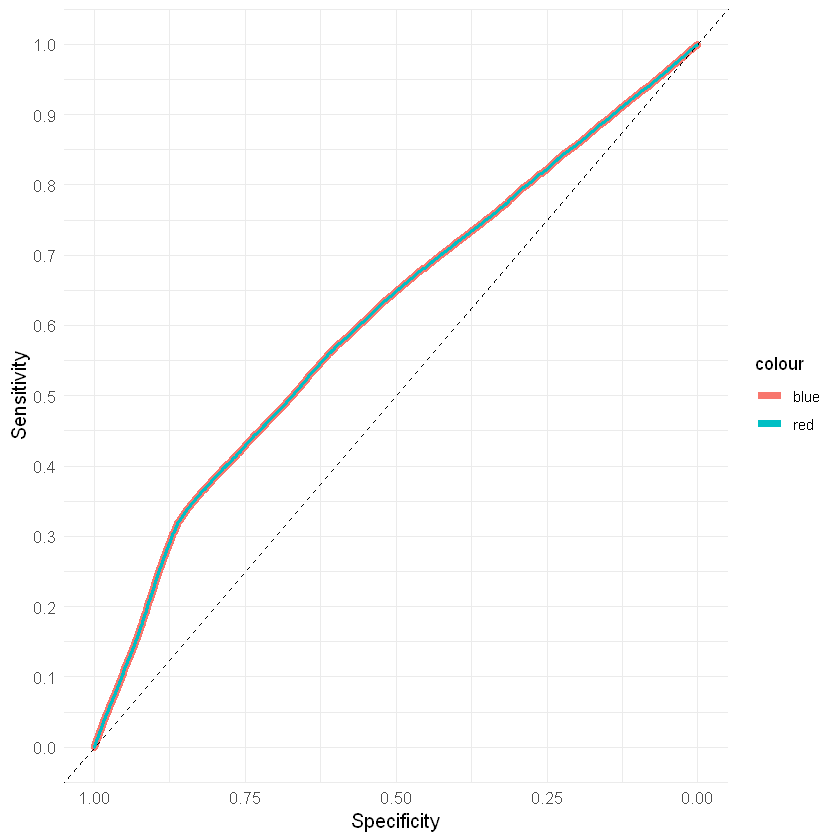

In [ ]:
# e a curva roc
library(pROC)
roc1 <- first$roc
roc2 <- last$roc

tibble(
    roc1_spec = roc1$specificities, 
    roc2_spec = roc2$specificities, 
    roc1_sens = roc1$sensitivities, 
    roc2_sens = roc2$sensitivities
) -> rocs
ggplot(data = rocs) + 
  geom_line(aes(x = roc1_spec, y = roc1_sens, color = "blue"), linetype = 1, size = 2) +
  geom_line(aes(x = roc2_spec, y = roc2_sens, color = "red"), linetype = 1, size = 1) +
  geom_abline(intercept = 1, slope = 1, linetype = "dashed", color = "black") +  # Add the 0.5 line
  labs(x = "Specificity", y = "Sensitivity") +
  scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.1)) +
  scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.1)) +
  scale_x_reverse() + 
  theme_minimal() +
  theme(
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )# + 
  #scale_fill_discrete(labels = c("ROC antes", "ROC depois"))
ggsave(here("relatorio", "curvas_roc.png"), width=10,height = 10)

In [ ]:
rocs

roc1_spec,roc2_spec,roc1_sens,roc2_sens
<dbl>,<dbl>,<dbl>,<dbl>
0.00000000000,0.00000000000,1.0000000,1.0000000
0.00001691761,0.00001691761,1.0000000,1.0000000
0.00003383522,0.00003383522,1.0000000,1.0000000
0.00005075283,0.00005075283,1.0000000,1.0000000
0.00005075283,0.00005075283,0.9999672,0.9999672
0.00005075283,0.00005075283,0.9999345,0.9999345
0.00006767044,0.00006767044,0.9999345,0.9999345
0.00006767044,0.00006767044,0.9999017,0.9999017
0.00008458806,0.00008458806,0.9999017,0.9999017


In [ ]:
rocs %>% 
    mutate(diff = roc1_spec != roc2_spec | roc1_sens != roc2_sens) %>% filter(diff)

mutate: new variable 'diff' (logical) with one unique value and 0% NA

filter: removed all rows (100%)



roc1_spec,roc2_spec,roc1_sens,roc2_sens,diff
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>


In [ ]:
# final vars explicitly
vars <- c(
    "winner.lastTournamentDelayW",
    "looser.lastTournamentDelayW",
    "match.domHands",
    "match.tournamentRound",
    "match.hadTieBreaker", 
    "tournament.dateDistance",
    "match.diffRank",
    "winner.bornAt",
    "looser.bornAt",
    "winner.heightF",
    "looser.heightF",
    "winner.winrate",
    "looser.winrate",
    "winner.njogos",
    "looser.njogos",
    "winner.nTournament",
    "looser.nTournament",
    "match.backHands",
    "tournament.durationF",
    "tournament.quarterL2",
    "tournament.prize"
)

In [ ]:
logistic_reg() %>% 
    fit(create.formula(input.names = vars, outcome.name = "match.setsCount", dat = df)$formula, data=df) %>% vip::vi() -> VI
VI %>% print(n=100)

# A tibble: 76 × 3
   Variable                                               Importance Sign 
   <chr>                                                       <dbl> <chr>
 1 match.hadTieBreakerTRUE                                   27.1    POS  
 2 match.diffRank                                             9.17   POS  
 3 winner.winrate                                             6.56   NEG  
 4 looser.winrate                                             4.74   POS  
 5 looser.njogos                                              3.86   POS  
 6 tournament.quarterL24                                      3.62   NEG  
 7 tournament.dateDistance                                    3.21   POS  
 8 tournament.durationF5                                      2.66   NEG  
 9 tournament.durationF6                                      2.58   NEG  
10 winner.bornAtUSA                                           2.54   NEG  
11 winner.heightF173                                          2.27   NEG  
12 mat

In [ ]:
VI %>% arrange(Variable) %>% print(n=100) 

# A tibble: 76 × 3
   Variable                                               Importance Sign 
   <chr>                                                       <dbl> <chr>
 1 looser.bornAtOther                                         0.0856 NEG  
 2 looser.bornAtUSA                                           0.358  POS  
 3 looser.heightF168                                          0.315  NEG  
 4 looser.heightF170                                          0.160  POS  
 5 looser.heightF173                                          0.145  POS  
 6 looser.heightF175                                          0.579  POS  
 7 looser.heightF178                                          0.739  POS  
 8 looser.heightF180                                          0.871  POS  
 9 looser.heightF183                                          0.688  POS  
10 looser.heightF185                                          0.654  POS  
11 looser.heightF188                                          0.752  POS  
12 loo

In [ ]:
# most relevant
rel_vars <- c(
    "winner.bornAt",
    "winner.heightF",
    "winner.lastTournamentDelayW",
    "winner.winrate",
    "looser.njogos",
    "looser.winrate",
    "match.diffRank",
    "match.domHands",
    "match.hadTieBreaker",
    "tournament.dateDistance",
    "tournament.durationF",
    "tournament.prize",
    "tournament.quarterL2"
)
length(rel_vars) - length(vars)

[1] -8

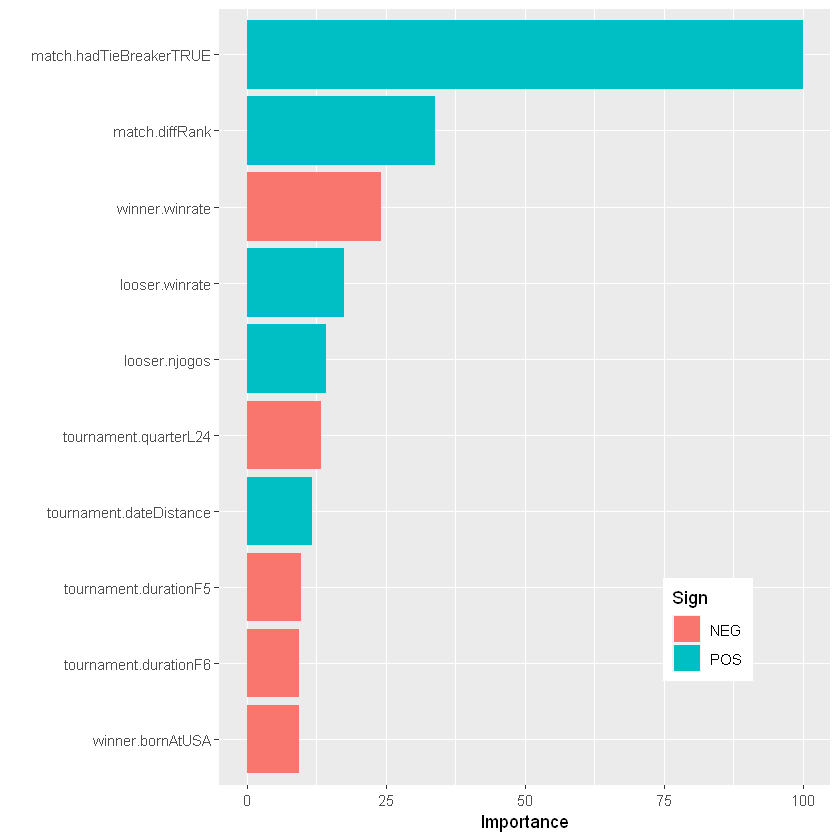

In [ ]:
logistic_reg() %>% 
    fit(create.formula(input.names = vars, outcome.name = "match.setsCount", dat = df)$formula, data=df) %>% 
    vip::vip(scale=TRUE, mapping = aes_string(fill = "Sign")) + theme(legend.position = c(0.8, 0.2))
ggsave(here("relatorio", "importancias.png"), width = 10, height = 10)

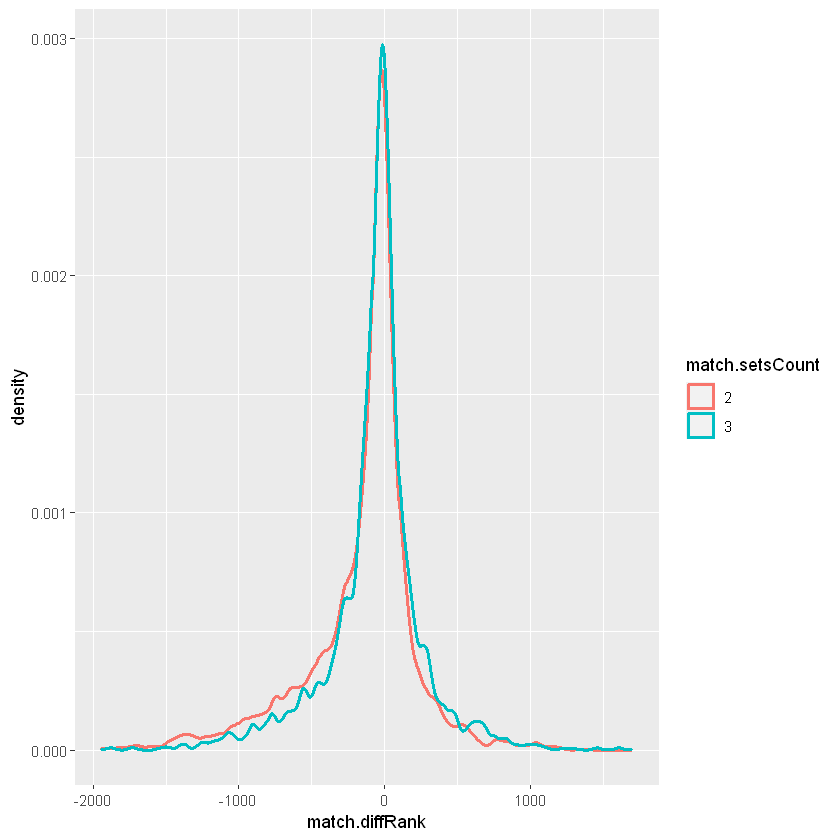

In [ ]:
ggplot(df, aes(color = match.setsCount, x = match.diffRank)) + geom_density(kernel="gaussian", size= 0.9)
ggsave(here("relatorio", "diffRank.png"), width = 11, height = 10)